<a href="https://colab.research.google.com/github/Aomaphisara/ULckdresearch2023/blob/main/SHAP_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


นำเข้าข้อมูลที่จัดกลุ่มแล้วจาก DBSCAN

In [129]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/ckd/clustering/data_DBSCAN_scale.csv")

In [130]:
data.head()

,Age,BMI,BSA,Diastolic-BP,Systolic-BP,G1M2-ARB,G3M1-Statin,G5M2-NSAIDs,G1M5-Diuretic,G1M7-Beta-blocker,...,L23-LDL-Cholesterol,L24-HDL-Cholesterol,L28-UrineProtein-Cr-ratio,InPatient,OutPatient,Emergency,LabLocation,NATNL,Sex,labels
0,0.531249,-1.055973,-1.625472,0.160130,-0.525000,2.991739,-0.698699,-0.129510,-0.176477,-0.333859,...,0.321723,3.686025,-1.158713,0,1,0,1,0,1,0
1,0.617111,-1.201074,-1.686392,-0.793624,-1.800103,2.991739,1.392719,-0.129510,-0.176477,-0.333859,...,0.983545,1.640595,-1.258996,0,1,0,1,0,1,0
2,0.702974,-1.077875,-1.686392,0.246834,0.112551,3.360578,1.625099,4.073425,-0.176477,-0.333859,...,0.494372,1.011232,-0.988847,0,1,0,1,0,1,0
3,0.788837,-1.201074,-1.808232,-0.620214,-0.119286,0.963126,-0.698699,-0.005894,2.205286,-0.333859,...,0.782121,1.876606,-0.884842,0,1,0,1,0,1,0
4,0.960563,-1.535080,-1.990992,-1.400558,-1.916021,3.360578,-0.698699,1.724726,-0.176477,-0.333859,...,0.494372,0.617880,-1.026662,0,1,0,1,0,1,0


In [131]:
# ลบข้อมูลที่มี labels เป็น -1 (ลบค่า Noise)
data_cleaned = data [data ['labels'] != -1]

# เปลี่ยนชื่อข้อมูลใน labels โดยที่ 0 จะกลายเป็น 1 และ 1 จะกลายเป็น 2
data_cleaned['labels'] = data_cleaned['labels'].replace({0: 1, 1: 2, 2: 3})
data = data_cleaned.copy()

<ipython-input-131-def3f4f9986e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['labels'] = data_cleaned['labels'].replace({0: 1, 1: 2, 2: 3})


In [85]:
#จาก52,620 เหลือ 51,091
data.shape

(51091, 73)

##RF

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import shap
import numpy as np

###กลุ่ม 1

In [88]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

#ปรับค่าในคอลัมน์ labels เพื่อให้กลุ่มที่เราสนใจเป็น 1 และกลุ่มอื่นๆเป็น 0:
data['labels'] = data['labels'].apply(lambda x: 1 if x == 1 else 0)


X = X = data.drop('labels', axis=1)  # ตัวแปรต้น
y = data['labels']  # ตัวแปรตาม (กลุ่ม 1 ,2,3)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a machine learning model
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make prediction on the testing data
y_pred = clf.predict(X_test)

# Classification Report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       626
           1       1.00      1.00      1.00     14702

    accuracy                           1.00     15328
   macro avg       1.00      0.99      0.99     15328
weighted avg       1.00      1.00      1.00     15328



In [109]:
explainer = shap.TreeExplainer(clf, X_test)
shap_values = explainer.shap_values(X_test, check_additivity=False)


100%|===================| 30649/30656 [09:39<00:00]       

In [112]:
print(shap_values.shape)
print(X_test.shape)

(15328, 72, 2)
(15328, 72)


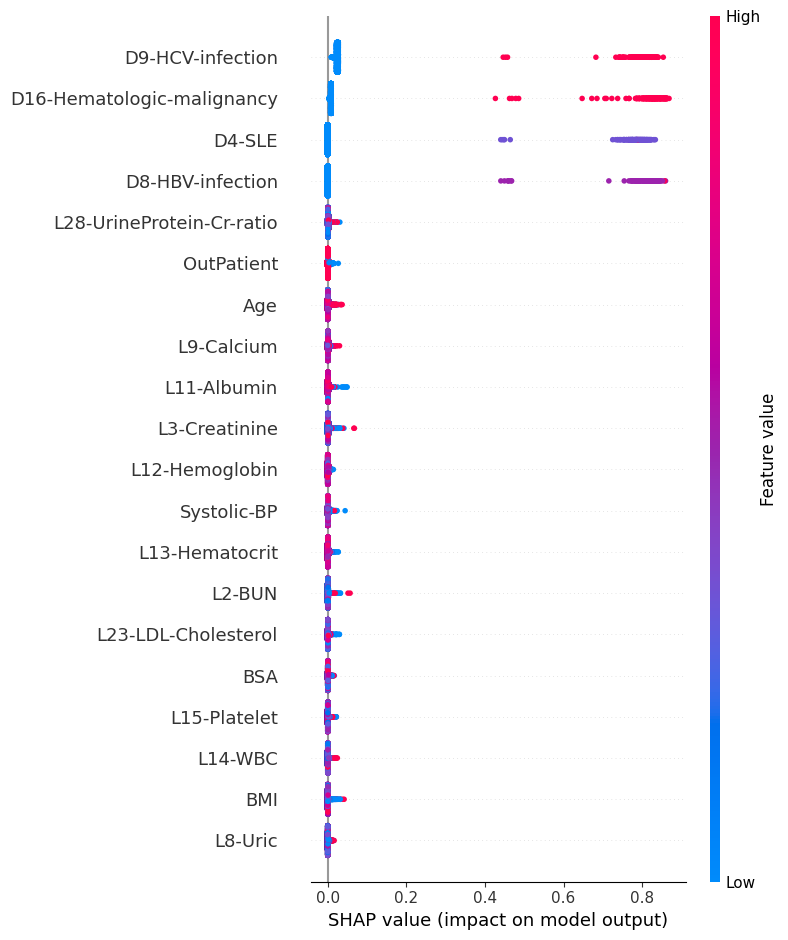

In [113]:
# Reshape shap_values array
shap_values_reshaped = np.mean(np.abs(shap_values), axis=2)
shap.summary_plot(shap_values_reshaped, X_test, feature_names=X.columns)

###กลุ่ม 2

In [125]:
# ปรับค่าในคอลัมน์ labels เพื่อให้กลุ่มที่เราสนใจเป็น 1 และกลุ่มอื่นๆเป็น 0:
data['labels'] = data['labels'].apply(lambda x: 1 if x == 2 else 0)

# เรียกใช้ฟังก์ชัน drop โดยตั้งค่า axis เป็น 1 เพื่อลบคอลัมน์ 'labels'
X = data.drop('labels', axis=1)
y = data['labels']

# แบ่งข้อมูลเป็นชุด train และ test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# สร้างแบบจำลอง
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# ทำนายบนชุดข้อมูลทดสอบ
y_pred = clf.predict(X_test)

# แสดงรายงานการประเมินผล
print(classification_report(y_pred, y_test))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15116
           1       1.00      0.96      0.98       212

    accuracy                           1.00     15328
   macro avg       1.00      0.98      0.99     15328
weighted avg       1.00      1.00      1.00     15328



In [126]:
explainer = shap.TreeExplainer(clf, X_test)
shap_values = explainer.shap_values(X_test, check_additivity=False)


100%|===================| 30552/30656 [03:39<00:00]       

In [127]:
print(shap_values.shape)
print(X_test.shape)

(15328, 72, 2)
(15328, 72)


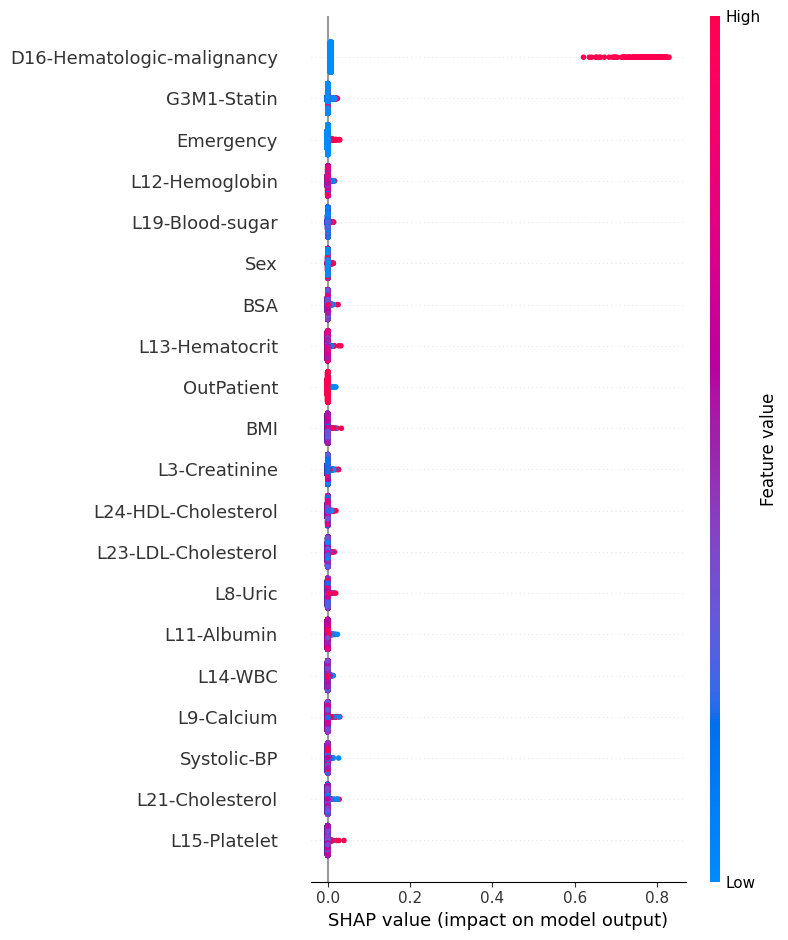

In [128]:
# Reshape shap_values array
shap_values_reshaped = np.mean(np.abs(shap_values), axis=2)
shap.summary_plot(shap_values_reshaped, X_test, feature_names=X.columns)

###กลุ่ม 3

In [132]:
# ปรับค่าในคอลัมน์ labels เพื่อให้กลุ่มที่เราสนใจเป็น 1 และกลุ่มอื่นๆเป็น 0:
data['labels'] = data['labels'].apply(lambda x: 1 if x == 3 else 0)

# เรียกใช้ฟังก์ชัน drop โดยตั้งค่า axis เป็น 1 เพื่อลบคอลัมน์ 'labels'
X = data.drop('labels', axis=1)
y = data['labels']

# แบ่งข้อมูลเป็นชุด train และ test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# สร้างแบบจำลอง
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# ทำนายบนชุดข้อมูลทดสอบ
y_pred = clf.predict(X_test)

# แสดงรายงานการประเมินผล
print(classification_report(y_pred, y_test))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14910
           1       1.00      0.98      0.99       418

    accuracy                           1.00     15328
   macro avg       1.00      0.99      0.99     15328
weighted avg       1.00      1.00      1.00     15328



In [133]:
explainer = shap.TreeExplainer(clf, X_test)
shap_values = explainer.shap_values(X_test, check_additivity=False)


100%|===================| 30595/30656 [07:53<00:00]       

In [134]:
print(shap_values.shape)
print(X_test.shape)

(15328, 72, 2)
(15328, 72)


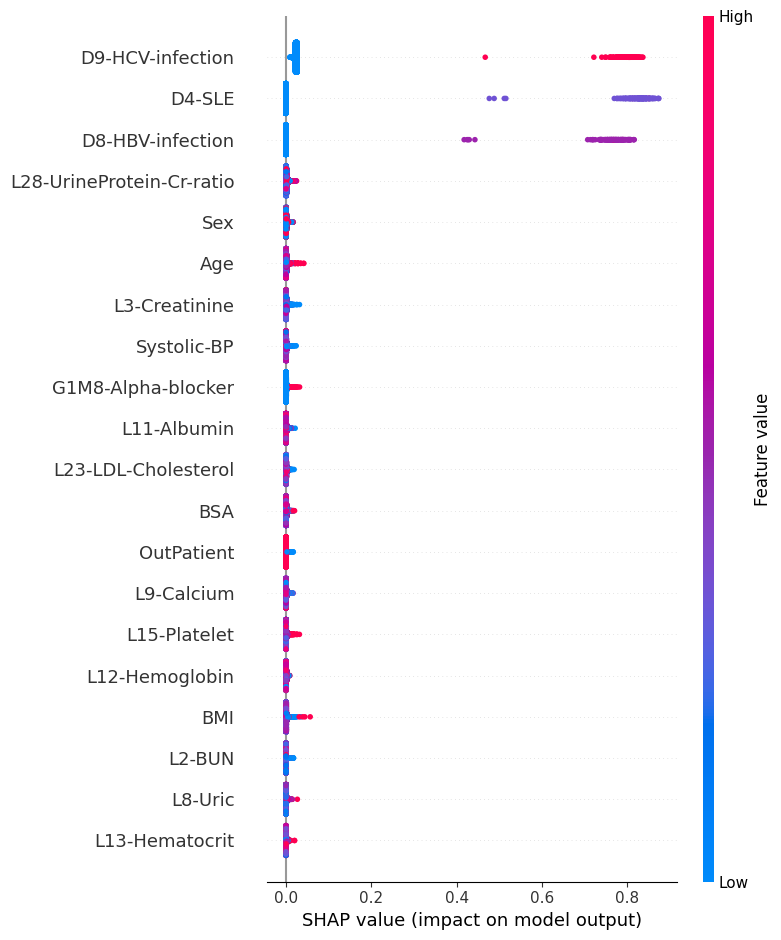

In [135]:
# Reshape shap_values array
shap_values_reshaped = np.mean(np.abs(shap_values), axis=2)
shap.summary_plot(shap_values_reshaped, X_test, feature_names=X.columns)

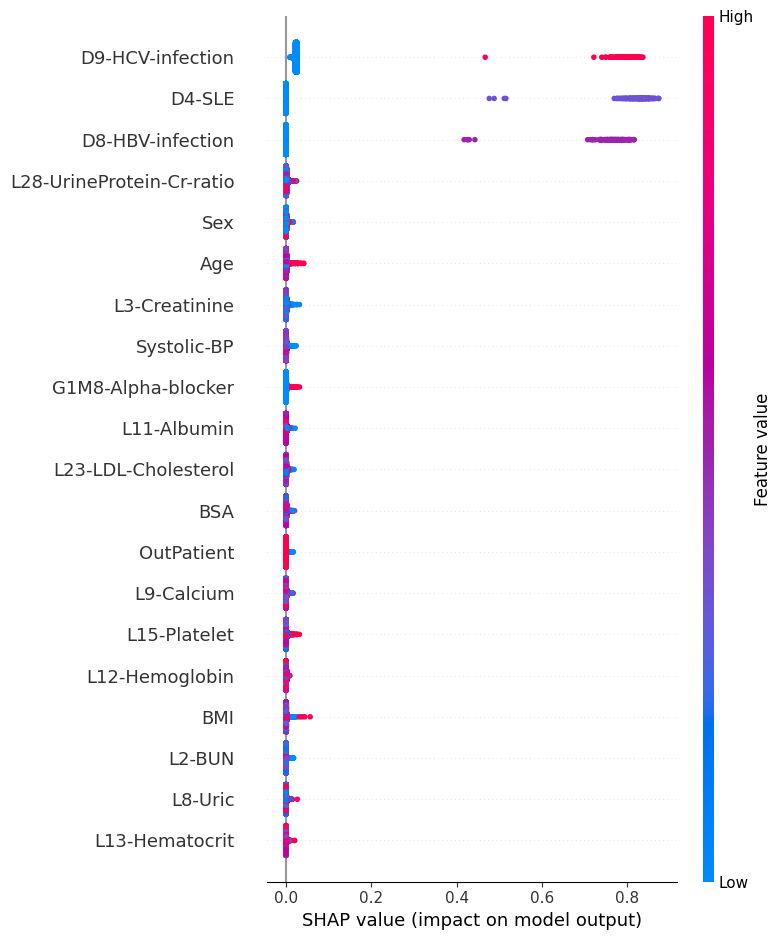

In [138]:
shap_values_reshaped = np.mean(np.abs(shap_values), axis=2)
shap.summary_plot(shap_values_reshaped, X_test, feature_names=X.columns)